In [1]:
import numpy as np
import scipy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy.io.ascii as asci
from helper import phys

In [2]:
from helper.specread import get_keck, gaplinelist, get_keck, get_hstspec, get_p200, get_ltspec
from helper.specread import add_telluric_circle, pblines
from helper.specplot_func import get_vvyy, add_tick,  plot_mask_gal_lines, measure_line_index, measure_abs_velocity
from helper.specplot_func import host_subtraction
from helper.specconvolve import convolve_with_constant_velocity_kernel
from allsn_info import get_at2019dge

In [14]:
import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [4]:
result = get_at2019dge()
z =result["z"]
t0max = result["t_max"]
ebv = result["ebv"]# galactic extinction
lc = result['tb']
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])

In [5]:
dt1 = get_keck(z=z, date = "20190412_Keck1_v2", vkernel = 200)
dt0 = get_keck(z=z, date = "20190704_Keck1_v1", vkernel = 200)
dt7 = get_keck(z=z, date = "20190928_Keck1_v1", vkernel = 200)
dt6 = get_keck(z=z, date = "20190831_Keck1_v1", vkernel = 200)
dt8 = get_keck(z=z, date = "20200218_Keck1_v2", vkernel = 200)
dt2 = get_p200(z=z)
dt3 = get_ltspec(date = '0410', z=z)
dt4 = get_ltspec(date = '0409', z=z)
dt5 = get_hstspec(z=z)

/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/specread.py:292: RuntimeWarning: invalid value encountered in log
  dt["ln_spec_obs"] = np.log(dt['spec_obs0'])
/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/specread.py:348: RuntimeWarning: invalid value encountered in log
  dt["ln_spec_obs"] = np.log(dt['spec_obs0'])


In [6]:
yaolist = gaplinelist(z=0)
H_list = yaolist['H_list']
FeII_list = yaolist['FeII_list']
HeI_list = yaolist['HeI_list']
HeII_list = yaolist['HeII_list']
OIII_list = yaolist['OIII_list']
OII_list = yaolist['OII_list']
OI_list = yaolist['OI_list']
SIII_list = yaolist['SIII_list']
SII_list = yaolist['SII_list']
NII_list = yaolist['NII_list']
CaII_list = yaolist['CaII_list']
NeIII_list = yaolist['NeIII_list']
ArIII_list = yaolist["ArIII_list"]
MgII_list = yaolist["MgII_list"]
CIII_list = yaolist["CIII_list"]
NIII_list = yaolist["NIII_list"]

select regions that should contain only galaxy light

In [23]:
gal_regions = np.array([[3350, 3900, 4200, 4420, 4600, 5150, 5540, 6030, 6400, 6860, 7540, 8250, 8870, 9400, 9800],
                        [3650, 4070, 4300, 4520, 4800, 5250, 5680, 6110, 6515, 6960, 7700, 8400, 9000, 9490, 10000]])

In [24]:
def visualize_subtraction(dt0, dt8):
    plt.figure(figsize = (10,6))
    ax = plt.subplot(111)
    x1_sub, y1_sub = host_subtraction(dt0['wave_con'], dt0['spec_con'], 
                                      dt8['wave_con'], dt8['spec_con'], gal_regions, fixb = True, plotax = ax)
    tup = 1.5e-16
    tbottom = -1e-16
    xoff = -30
    yoff = 0.06e-16
    ax.plot([OI_list[1], OI_list[1]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([OI_list[2], OI_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(OI_list[1]+xoff, tup+yoff, "[O I]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([CaII_list[2], CaII_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[3], CaII_list[3]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[3]+xoff*1.6, tup+yoff, "[Ca II]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([HeI_list[2], HeI_list[2]], [tbottom, tup], color='forestgreen', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[2]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "forestgreen")

    ax.plot([HeI_list[3], HeI_list[3]], [tbottom, tup], color='b', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[3]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "b", zorder = 6)

    ax.plot([HeI_list[4], HeI_list[4]], [tbottom, tup], color='crimson', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[4]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "crimson", zorder = 6)

    ax.plot([CaII_list[4], CaII_list[4]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[5], CaII_list[5]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[6], CaII_list[6]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[5]+xoff, tup+yoff, "Ca II", rotation=90, fontsize = fs-1, color = "darkcyan")
    ax.set_ylim(-5e-17, 2e-16)
    return x1_sub, y1_sub

<IPython.core.display.Javascript object>


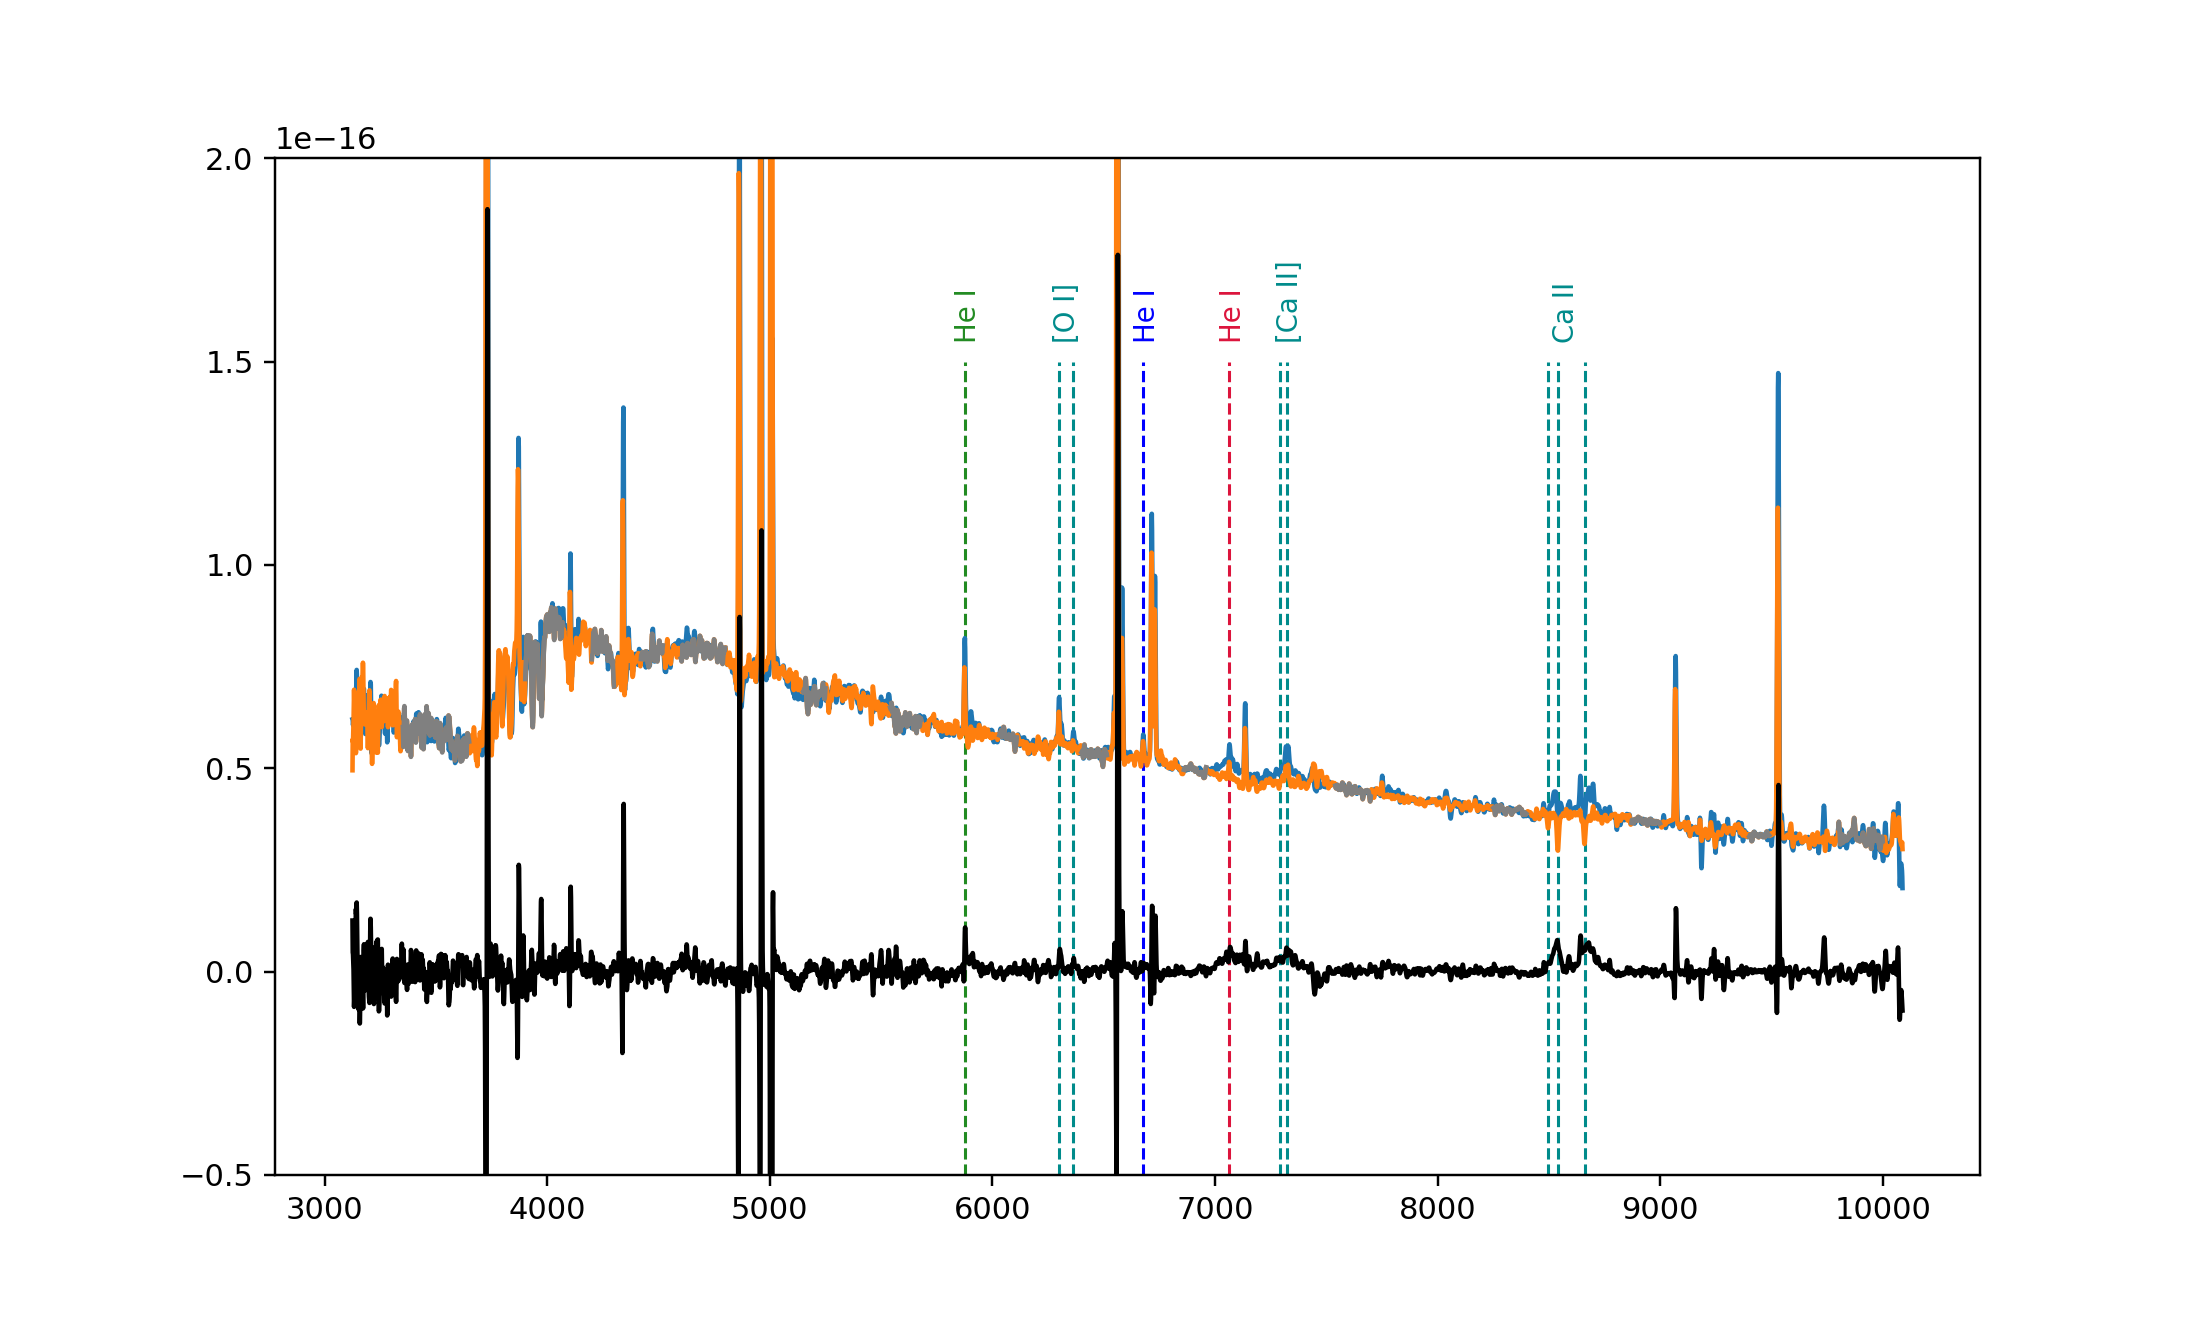

0
[1.019441   1.01099218 0.98302651 0.97855942 1.02947335 1.00925205
 0.99880884 0.99164225 1.01567617 0.96782345 0.97770862 0.97493822
 0.99513    1.0232284  1.03609022]


In [25]:
x1_sub, y1_sub = visualize_subtraction(dt0, dt8)

<IPython.core.display.Javascript object>


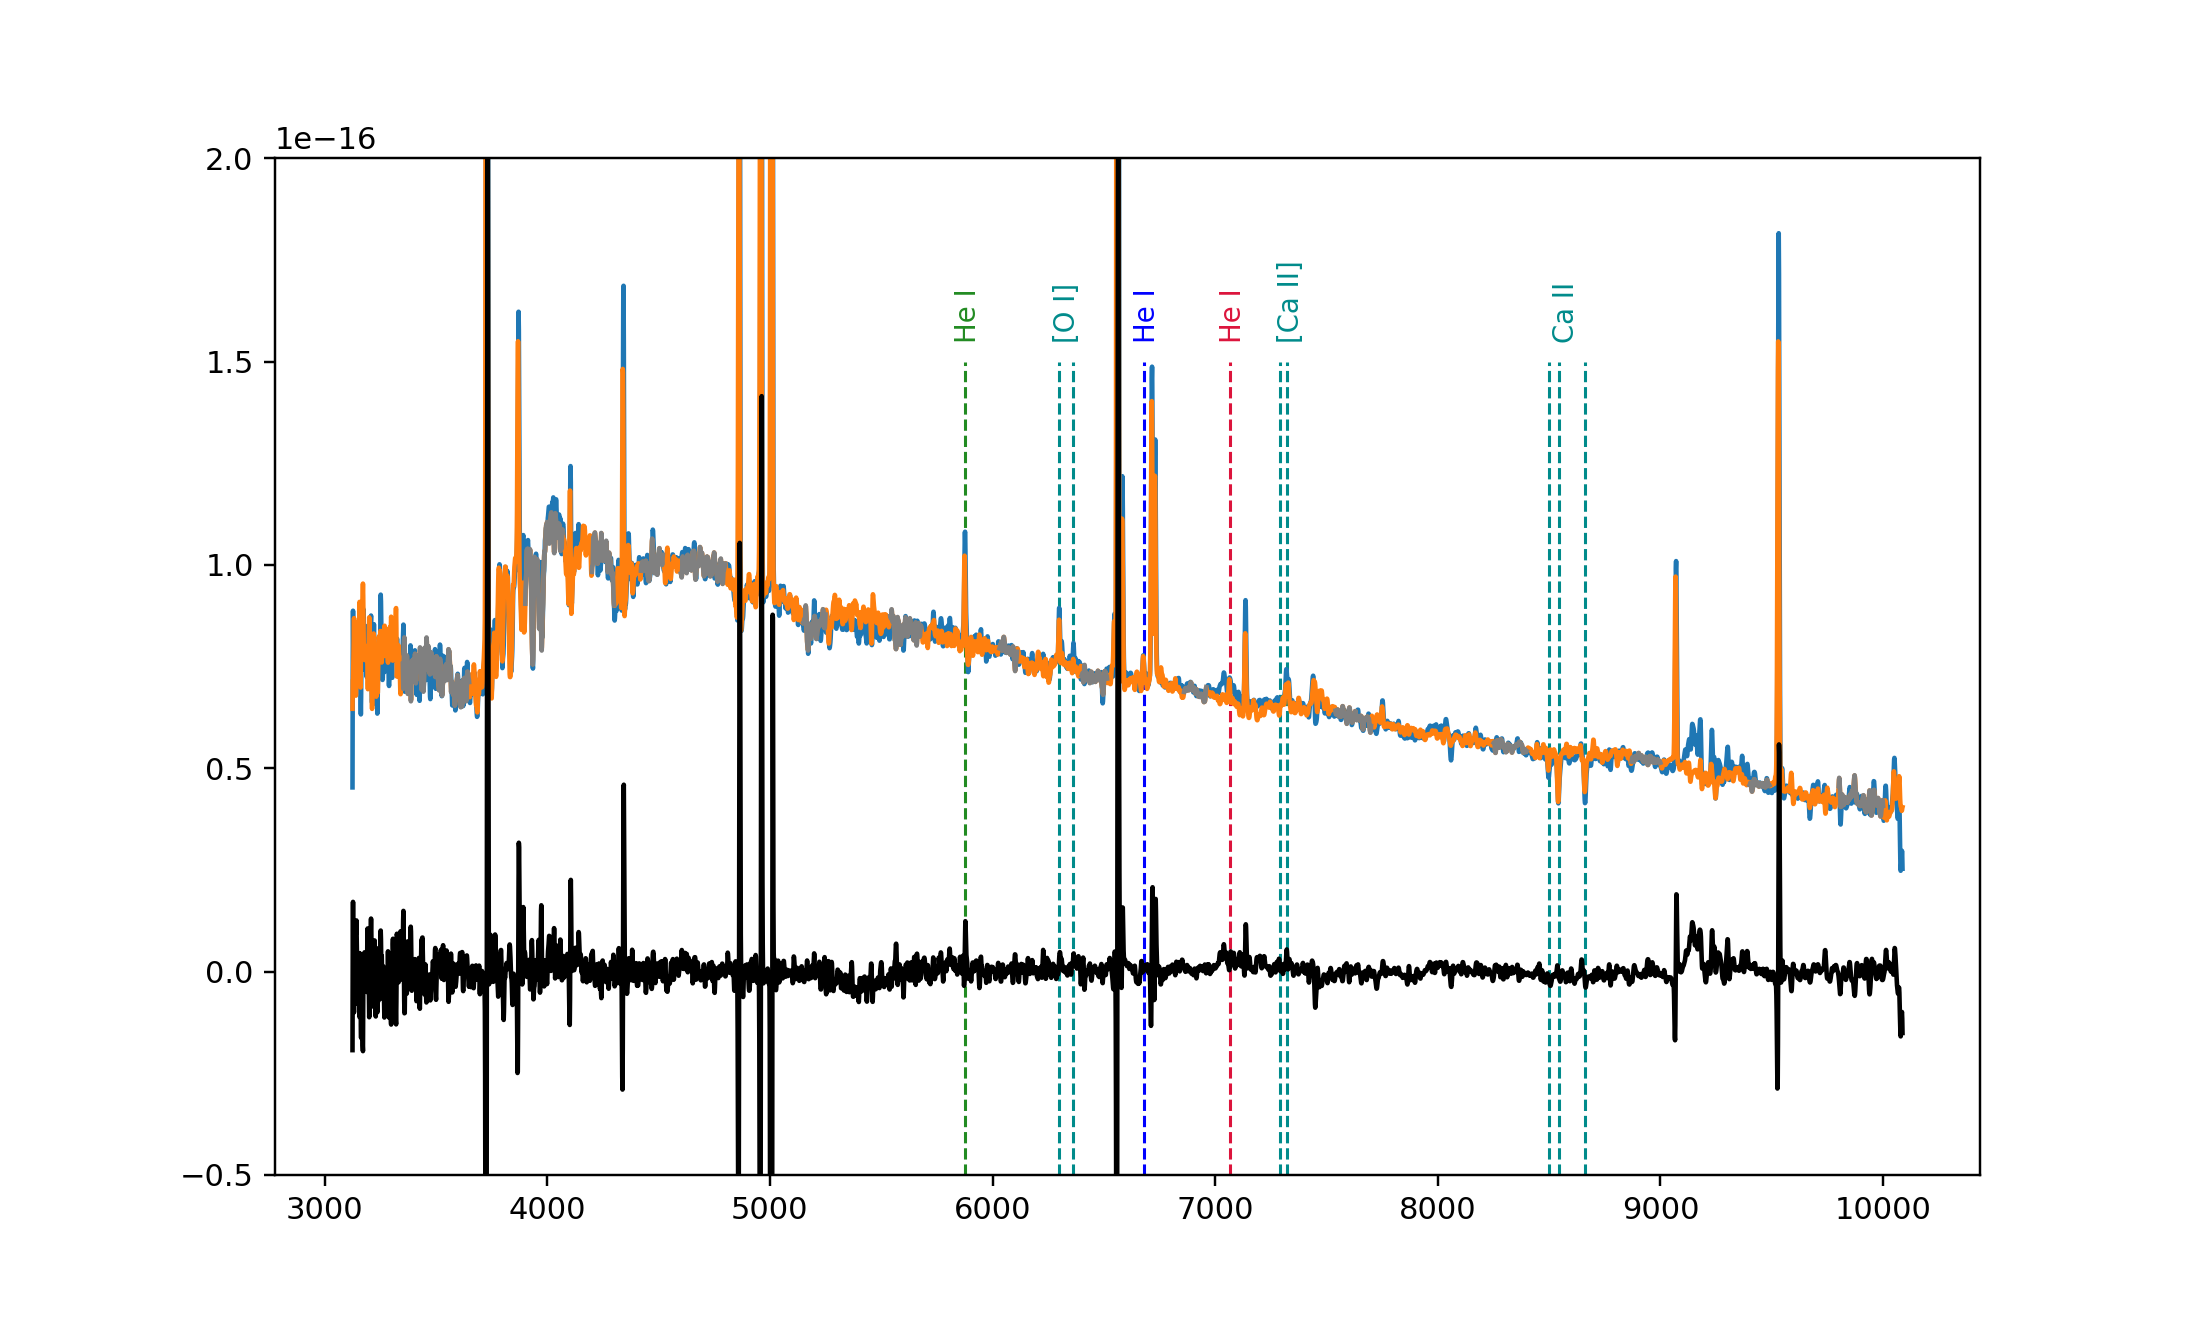

0
[0.98249064 0.97308258 0.96707178 0.96036265 0.9956331  0.96270034
 1.04527433 1.0384961  1.04846198 1.0309002  1.05190295 1.04109724
 1.07737276 1.07882207 1.00843279]


In [26]:
x2_sub, y2_sub = visualize_subtraction(dt6, dt8)

<IPython.core.display.Javascript object>


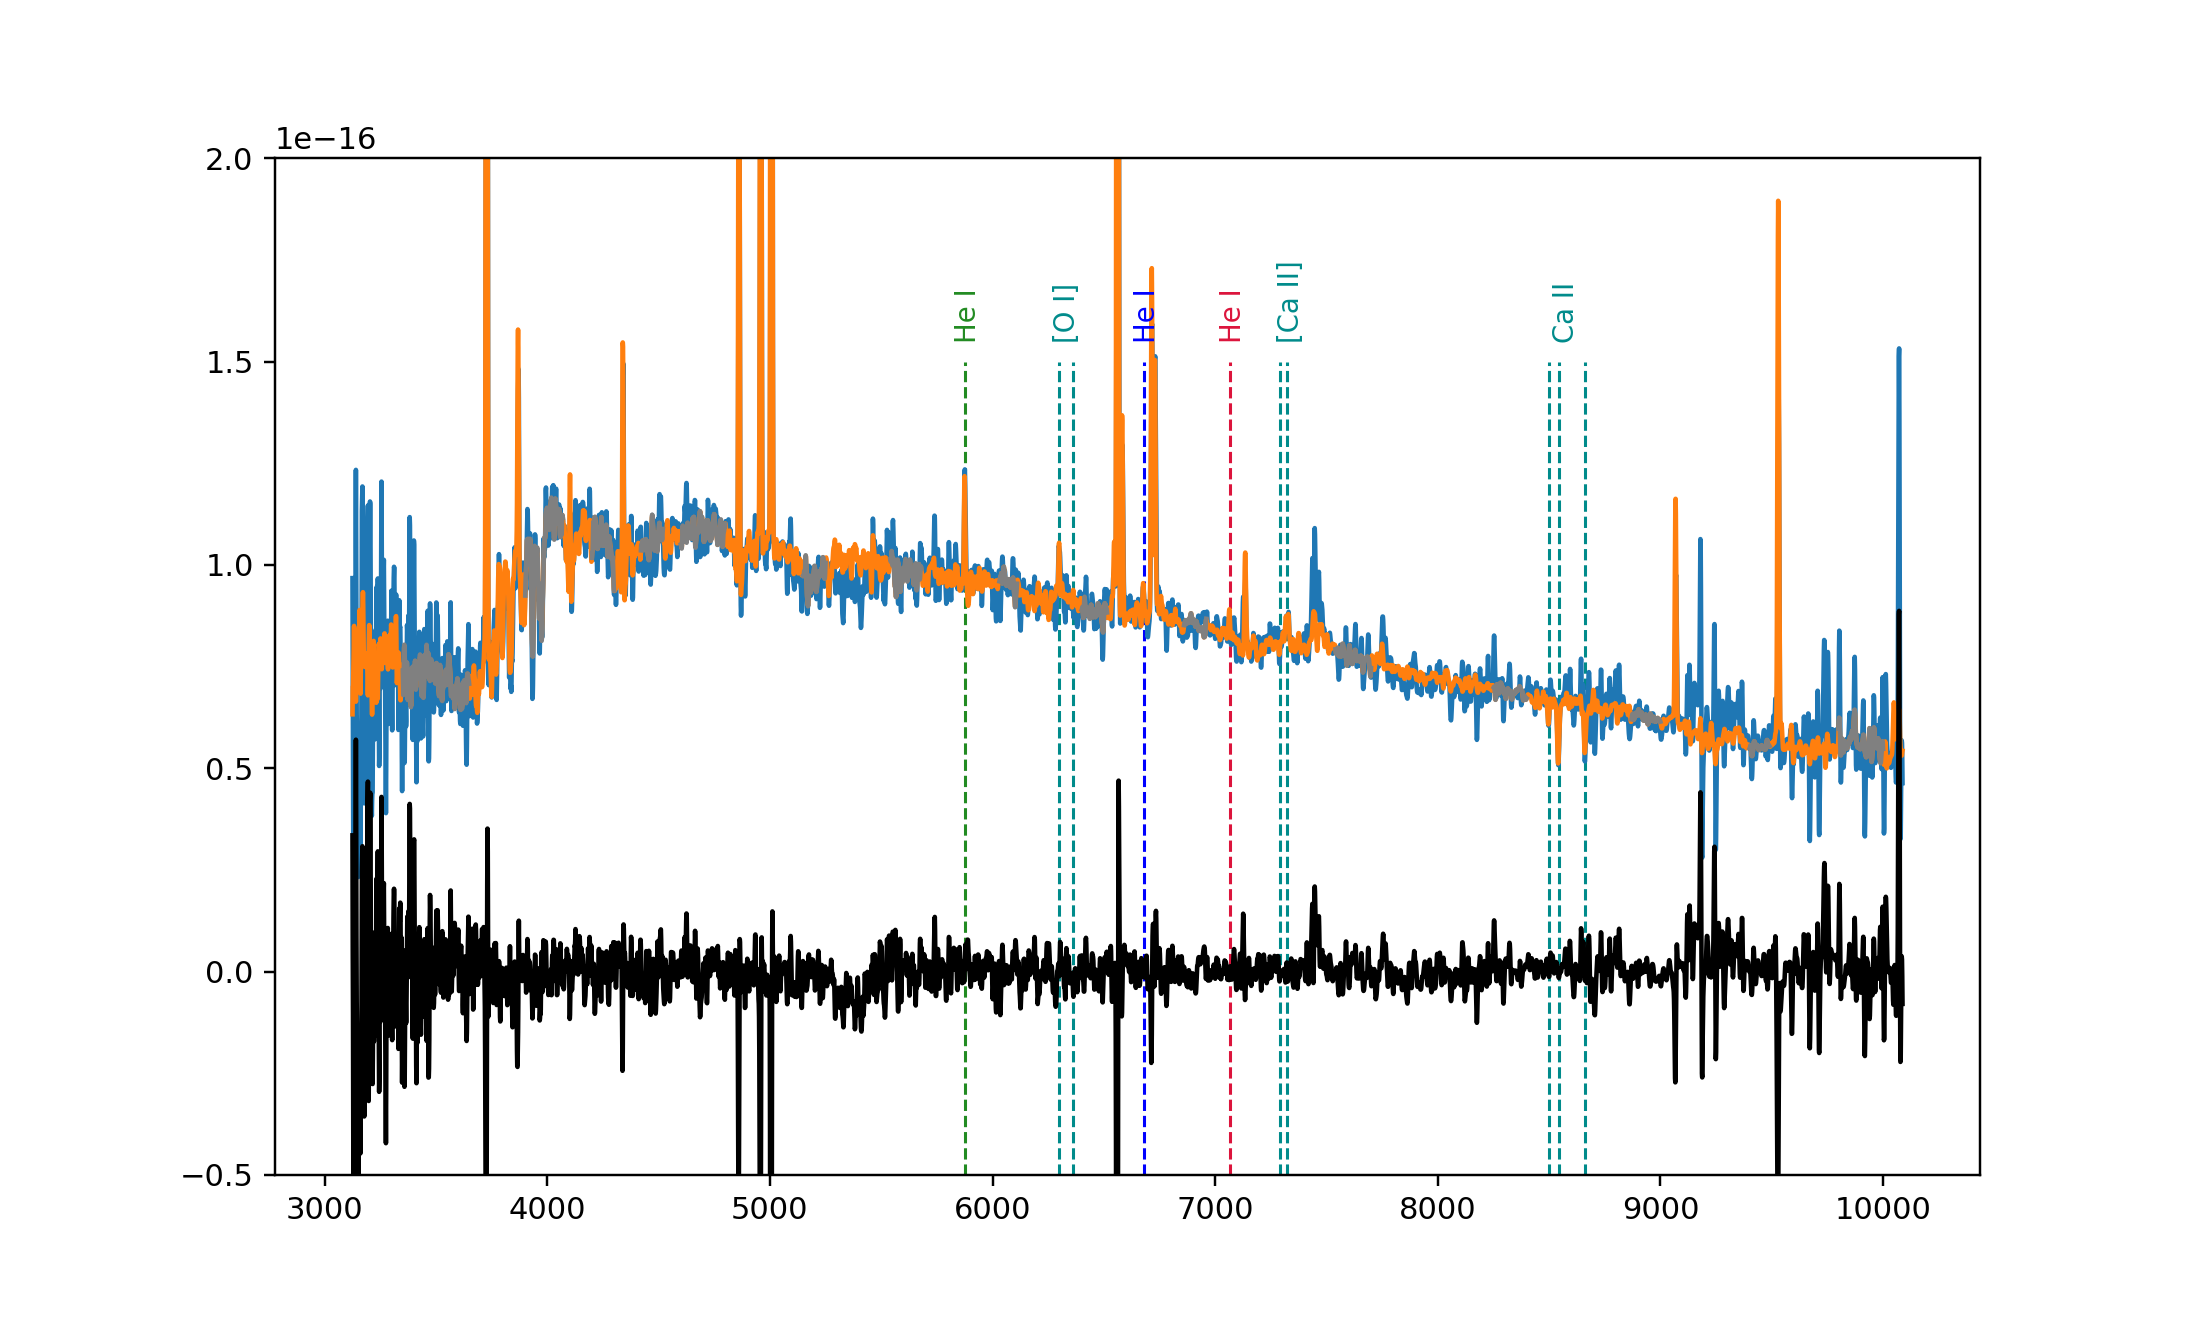

0
[0.85833488 0.89662032 0.89519985 0.90503915 0.96614006 0.98137178
 1.08701441 1.12385441 1.14603489 1.14237606 1.16022779 1.15674886
 1.15178633 1.15409195 1.21065398]


In [27]:
x3_sub, y3_sub = visualize_subtraction(dt7, dt8)

In [28]:
ww1, ff1 = convolve_with_constant_velocity_kernel(x1_sub, y1_sub, 300)
ww2, ff2 = convolve_with_constant_velocity_kernel(x2_sub, y2_sub, 300)
ww3, ff3 = convolve_with_constant_velocity_kernel(x3_sub, y3_sub, 300)

In [11]:
sp14gqr = np.loadtxt("../data/otherSN/De2018/2014ft_2014-11-19_06-29-00_Keck1_LRIS_iPTF.ascii")
sp06qp = pd.read_csv("../data/otherSN/SN2006qp/phase32")
sp12aw = pd.read_csv("../data/otherSN/SN2012aw/phase213")

In [12]:
wv14gqr = sp14gqr[:, 0] / (1+0.063)
fl14gqr = sp14gqr[:, 1]
wv14gqr_, fl14gqr_ =  convolve_with_constant_velocity_kernel(wv14gqr, fl14gqr, 300)

wv06qp = sp06qp["wavelength"].values[100:]/ (1+0.012)
fl06qp = sp06qp["flux"].values[100:]
wv06qp_, fl06qp_ =  convolve_with_constant_velocity_kernel(wv06qp, fl06qp, 300)

wv12aw = sp12aw["wavelength"].values/ (1+0.002595)
fl12aw = sp12aw["flux"].values
wv12aw_, fl12aw_ =  convolve_with_constant_velocity_kernel(wv12aw, fl12aw, 300)

<IPython.core.display.Javascript object>


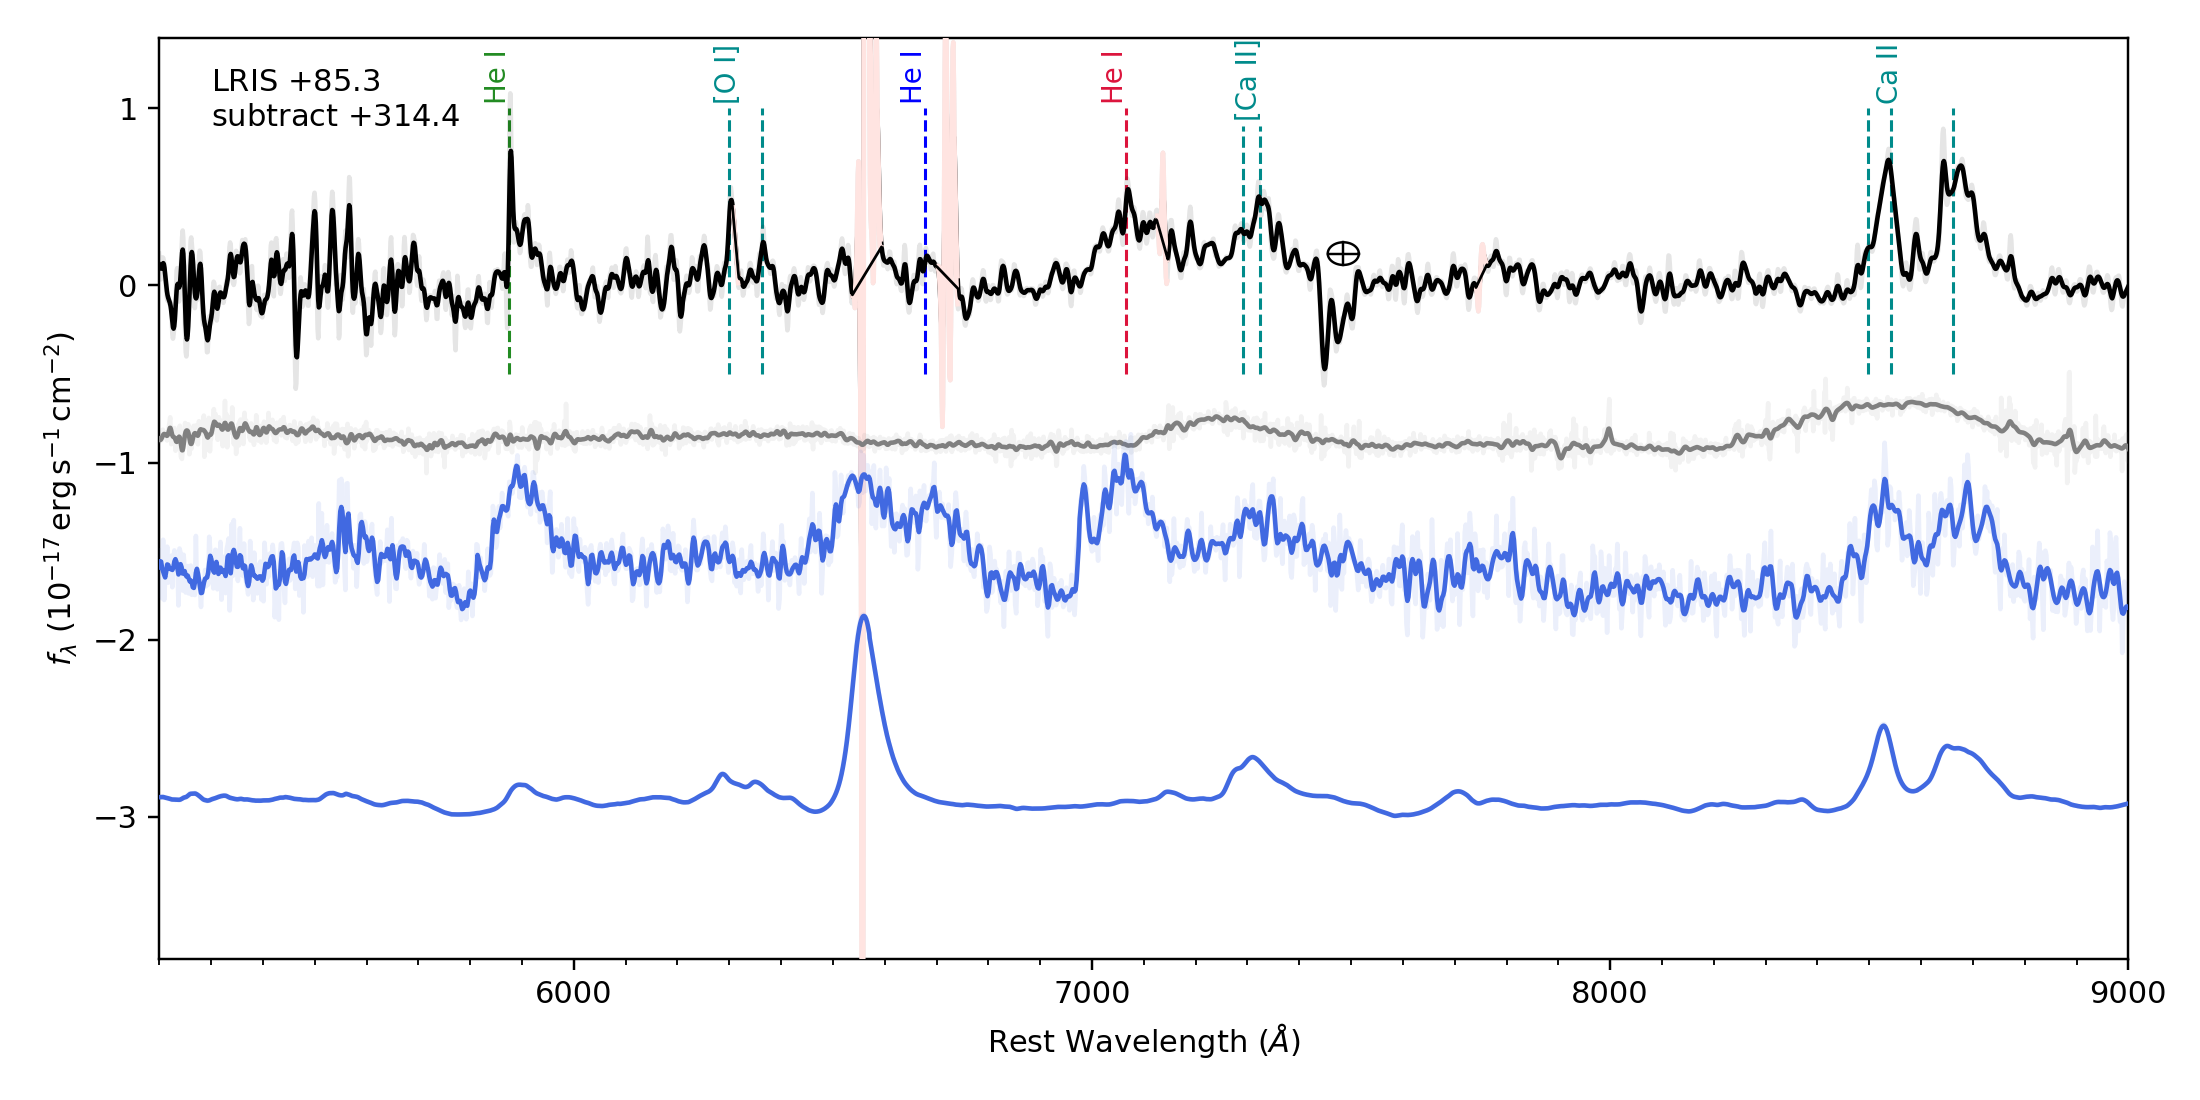

In [41]:
    fig = plt.figure(figsize=(10, 5.))
    ax = plt.subplot(111)
    
    ax.plot(x1_sub, y1_sub*1e+17, 'k', alpha = 0.1)
    plot_mask_gal_lines(ax, x1_sub, y1_sub*1e+17, plotfinal = False)
    ax.plot(ww1, ff1*1e+17, 'k', alpha = 1)
    plot_mask_gal_lines(ax, ww1, ff1*1e+17, plotfinal = True)
    
    xtext = 5300
    ax.text(xtext, 1.1, 'LRIS $+%.1f$'%dt0["phase"], zorder = 6)
    ax.text(xtext, 0.9, 'subtract $+%.1f$'%dt8["phase"], zorder = 6)
    
    
    """
    yoff2 = -1
    ax.plot(x2_sub, y2_sub*1e+17+yoff2, 'k', alpha = 0.1)
    plot_mask_gal_lines(ax, x2_sub, y2_sub*1e+17+yoff2, plotfinal = False)
    ax.plot(ww2, ff2*1e+17+yoff2, 'k', alpha = 1)
    plot_mask_gal_lines(ax, ww2, ff2*1e+17+yoff2, plotfinal = True)
    
    yoff3 = -2
    ax.plot(x3_sub, y3_sub*1e+17+yoff3, 'k', alpha = 0.1)
    plot_mask_gal_lines(ax, x3_sub, y3_sub*1e+17+yoff3, plotfinal = False)
    ax.plot(ww3, ff3*1e+17+yoff3, 'k', alpha = 1)
    plot_mask_gal_lines(ax, ww3, ff3*1e+17+yoff3, plotfinal = True)
    """
    ax.set_ylim(-3.8, 1.4)
    ax.set_xlim(5200, 9000)
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    ax.set_xlabel('Rest Wavelength ('+r'$\AA$'+')')
    ax.set_ylabel(r'$f_{\lambda}$'+ " ("+r"$10^{-17}\,{\rm erg\,s^{-1}\, cm^{-2}}$"+ ")")
    
    tup = 1
    tbottom = -0.5
    xoff = -30
    yoff = 0.06
    ax.plot([OI_list[1], OI_list[1]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([OI_list[2], OI_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(OI_list[1]+xoff, tup+yoff, "[O I]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([CaII_list[2], CaII_list[2]], [tbottom, tup-0.1], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[3], CaII_list[3]], [tbottom, tup-0.1], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[3]+xoff*1.6, tup+yoff-0.1, "[Ca II]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([HeI_list[2], HeI_list[2]], [tbottom, tup], color='forestgreen', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[2]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "forestgreen")

    ax.plot([HeI_list[3], HeI_list[3]], [tbottom, tup], color='b', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[3]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "b", zorder = 6)

    ax.plot([HeI_list[4], HeI_list[4]], [tbottom, tup], color='crimson', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[4]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "crimson", zorder = 6)

    ax.plot([CaII_list[4], CaII_list[4]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[5], CaII_list[5]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[6], CaII_list[6]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[5]+xoff, tup+yoff, "Ca II", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    
    color = "gray"
    ax.plot(wv14gqr, fl14gqr*1e+17-1, zorder = 6, color = color, alpha = 0.1)
    ax.plot(wv14gqr_, fl14gqr_*1e+17-1, zorder = 6, color = color, alpha = 1)
    
    color = "royalblue"
    ax.plot(wv06qp, fl06qp*10-2, zorder = 6, color = color, alpha = 0.1)
    ax.plot(wv06qp_, fl06qp_*10-2, zorder = 6, color = color, alpha = 1)
    
    ax.plot(wv12aw, fl12aw*2e+14-3, zorder = 6, color = color, alpha = 0.1)
    ax.plot(wv12aw_, fl12aw_*2e+14-3, zorder = 6, color = color, alpha = 1)
    
    
    add_telluric_circle(ax, 7485, 0.18, rx=30, ry = 0.08*4/5, ls=0.8)
    plt.tight_layout()
    plt.savefig("../paper/figures/spec_host_subtracted.pdf")